In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
# from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC


<br>

## 1. Preparing dataset

In [2]:
data_df = pd.read_csv('titanic.csv')
data_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Data info

- **PassengerId** : Unique ID of passenger
- **Survived** : 0 = No, 1 = Yes
- **pclass** : Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- **sibsp** : # of siblings & spouses aboard the Titanic
- **parch** : # of parents / children aboard the Titanic
- **ticket** : Ticket number
- **cabin** : Cabin number
- **embarked** : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [3]:
# 종속변수 분리 / 예측값 따로 저장
y_data = data_df[['Survived']]
# y_data.head(3)

In [4]:
del data_df['Survived']
x_data = data_df.copy()
# x_data.head(3)

<br>

## 2. Feature engineering & Feature selection

#### 시도해볼 수 있는 전략들

- 불필요한 열이나 예측에 방해가 되는 열은 아예 지우기 (ex. PassengerId)
- 결측치 채우기 
- Text로 되어있는 Category(Factor)는 숫자로 바꿔주기 (ex. Male/Female -> 0/1)
- 실수 범위를 구간 범위로 바꿔주기 
- 필요한 경우 기존 열을 바탕으로 새로운 열을 계산해 추가하기

In [5]:
# 지우기 전 열 확인
x_data.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
# 필요없는 열 한꺼번에 지우기
del_columns = ['PassengerId', 'Ticket', 'Fare', "Cabin", "Embarked"]

x_data.drop(labels = del_columns, axis = 1, inplace =True)

In [7]:
# 결측치 가지고 있는 열 확인
x_data.isnull().sum()

# Age 가 177개의 결측치를 가지고 있음

Pclass      0
Name        0
Sex         0
Age       177
SibSp       0
Parch       0
dtype: int64

In [8]:
# age 결측치 채우기 -> 중앙값으로 채우기
median_age = x_data['Age'].median(skipna=True)
x_data['Age'] = x_data['Age'].fillna(median_age) # or .fillna(int/float/str 값)

In [9]:
# 결측치 없는 것 확인
x_data.isnull().sum()

Pclass    0
Name      0
Sex       0
Age       0
SibSp     0
Parch     0
dtype: int64

In [10]:
# age_grouping
x_data.loc[x_data["Age"] <= 10, "age_group"] = 0 # 10대 미만
x_data.loc[(x_data["Age"] > 10) & (x_data["Age"] <= 16), "age_group"] = 1 # 10대
x_data.loc[(x_data["Age"] > 16) & (x_data["Age"] <= 20), "age_group"] = 2 # 20대
x_data.loc[(x_data["Age"] > 20) & (x_data["Age"] <= 26), "age_group"] = 3 # 30대
x_data.loc[(x_data["Age"] > 26) & (x_data["Age"] <= 30), "age_group"] = 4 # 40대
x_data.loc[(x_data["Age"] > 30) & (x_data["Age"] <= 36), "age_group"] = 5 # 50대
x_data.loc[(x_data["Age"] > 36) & (x_data["Age"] <= 40), "age_group"] = 6 # 50대
x_data.loc[(x_data["Age"] > 40) & (x_data["Age"] <= 46), "age_group"] = 7 # 50대
x_data.loc[(x_data["Age"] > 46) & (x_data["Age"] <= 50), "age_group"] = 8 # 50대
x_data.loc[(x_data["Age"] > 50) & (x_data["Age"] <= 60), "age_group"] = 9 # 50대
x_data.loc[x_data["Age"] > 60, "age_group"] = 10 # 60대 이상

In [11]:
# 성별 분류
x_data.loc[x_data["Sex"] == "male", "Sex_group"] = 0
x_data.loc[x_data["Sex"] == "female", "Sex_group"] = 1

In [12]:
# int 형으로 데이터 타입 변경
x_data["age_group"] = x_data["age_group"].astype('int')
x_data["Sex_group"] = x_data["Sex_group"].astype('int')
x_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,age_group,Sex_group
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,3,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,6,1
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,3,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,5,1
4,3,"Allen, Mr. William Henry",male,35.0,0,0,5,0


In [13]:
# 원데이터 보존 
x_data_num = x_data.copy()

# text 데이터 제거
del_col2 = ["Name", "Sex"]

x_data_num.drop(labels = del_col2, axis=1, inplace = True)

In [14]:
x_data_num

,Pclass,Age,SibSp,Parch,age_group,Sex_group
0,3,22.0,1,0,3,0
1,1,38.0,1,0,6,1
2,3,26.0,0,0,3,1
3,1,35.0,1,0,5,1
4,3,35.0,0,0,5,0
...,...,...,...,...,...,...
886,2,27.0,0,0,4,0
887,1,19.0,0,0,2,1
888,3,28.0,1,2,4,1
889,1,26.0,0,0,3,0


In [15]:
# age_group 만 있는 데이터
x_data_num_cate = x_data_num.iloc[:, [0,2,3,4,5]]
# 사용한 열 : pcalss, age_group, sibsp, parch, sex_group

# age 실수형으로 들어간 데이터
x_data_num_conti = x_data_num.iloc[:, [0,1,2,3,5]]
# 사용한 열 : pcalss, age, sibsp, parch, sex_group
x_data_num_conti.head()

,Pclass,Age,SibSp,Parch,Sex_group
0,3,22.0,1,0,0
1,1,38.0,1,0,1
2,3,26.0,0,0,1
3,1,35.0,1,0,1
4,3,35.0,0,0,0


<br>

## 2. Train 및 모델 비교

<br>
<br>

### 비교할 데이터 2개 : 실수형 age - x_data_num_conti / 범주형 x_data_num_cate

### 2-1. 범주형 age - 모델링

In [16]:
# train - test split : 범주형
X_train, X_test, y_train, y_test = train_test_split(
    x_data_num_cate, y_data,test_size = 0.3, random_state=0)

# 모델링
# parameter 미 조정한 모델
svc = SVC()
svc.fit(X_train, y_train)

print("Accuracy on Training set: {:.3f}".format(svc.score(X_train, y_train)))
print("Accuracy on Test set: {:.3f}".format(svc.score(X_test, y_test)))

Accuracy on Training set: 0.841
Accuracy on Test set: 0.810


In [17]:
# normalization
min_on_training = X_train.min(axis=0) # 열마다의 최소값 계산
range_on_training = (X_train - min_on_training).max(axis=0) # 분모에 해당 
X_train_scaled = (X_train - min_on_training) / range_on_training # Min-max scaling (0~1)
X_test_scaled = (X_test - min_on_training) / range_on_training

# print("열마다의 최소값\n{}".format(X_train_scaled.min(axis=0)))
# print("열마다의 최대값\n {}".format(X_train_scaled.max(axis=0)))

In [18]:
# 최적의 parameter 값 찾기
from sklearn.model_selection import GridSearchCV

param_grid = {'C' : [0.1, 1, 10, 100, 1000], 
             'gamma' : [1, 0.1, 0.01, 0.001, 0.0001],
             'kernel' : ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1)

grid.fit(X_train_scaled, y_train)
print('The best parameters are ', grid.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The best parameters are  {'C': 100, 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.8s finished


In [19]:
# age_category / scaled

# best parameter로 모델링하기
svc = SVC(C=100, gamma=1, probability= True)
svc.fit(X_train_scaled, y_train)

print("Accuracy on Training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on Test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on Training set: 0.838
Accuracy on Test set: 0.810


<br>
<br>

## 범주형 age 모델 성능평가 01 - accuracy

In [20]:
# 예측 및 성능평가
from sklearn.metrics import classification_report

grid_predictions = grid.predict(X_test_scaled)
print(classification_report(y_test, grid_predictions)) # Precision, Recall, F1-score 등을 확인할 수 있습니다.

print("Accuracy on Training set: {:.3f}".format(grid.score(X_train_scaled, y_train)))
print("Accuracy on Test set: {:.3f}".format(grid.score(X_test_scaled, y_test)))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       168
           1       0.76      0.71      0.74       100

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.81      0.81      0.81       268

Accuracy on Training set: 0.838
Accuracy on Test set: 0.810


<br>
<br>

## 범주형 age 모델 성능평가 02 - ROC curve

In [21]:
pred_test = svc.predict_proba(X_test) # Predict 'probability'

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true=y_test, y_score=pred_test[:,1]) # real y & predicted y (based on "Sepal width")
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)
roc_auc

0.45446428571428577

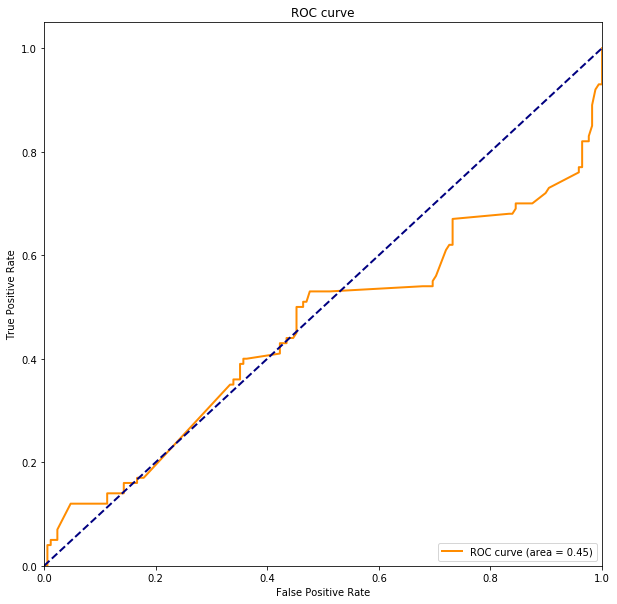

In [22]:
plt.figure(figsize=(10, 10))

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")

plt.show()

<br>
<br>

### 2-2 실수형 Age - 모델링

In [23]:
# train - test split : 실수형 age_continous
X_train, X_test, y_train, y_test = train_test_split(
    x_data_num_conti, y_data,test_size = 0.3, random_state=0)

# 모델링
# parameter 미 조정한 모델
svc = SVC()
svc.fit(X_train, y_train)

print("Accuracy on Training set: {:.3f}".format(svc.score(X_train, y_train)))
print("Accuracy on Test set: {:.3f}".format(svc.score(X_test, y_test)))

Accuracy on Training set: 0.873
Accuracy on Test set: 0.802


In [24]:
# normalization 
min_on_training = X_train.min(axis=0) # 열마다의 최소값 계산
range_on_training = (X_train - min_on_training).max(axis=0) # 분모에 해당 
X_train_scaled = (X_train - min_on_training) / range_on_training # Min-max scaling (0~1)
X_test_scaled = (X_test - min_on_training) / range_on_training

# print("열마다의 최소값\n{}".format(X_train_scaled.min(axis=0)))
# print("열마다의 최대값\n {}".format(X_train_scaled.max(axis=0)))

In [25]:
from sklearn.model_selection import GridSearchCV

# 최적의 parameter 찾기 
param_grid = {'C' : [0.1, 1, 10, 100, 1000], 
             'gamma' : [1, 0.1, 0.01, 0.001, 0.0001],
             'kernel' : ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1)

grid.fit(X_train_scaled, y_train)
print('The best parameters are ', grid.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The best parameters are  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.6s finished


In [26]:
# age_conti / scaled

# best parameter 적용 
svc = SVC(C=10, gamma=1, probability= True)
svc.fit(X_train_scaled, y_train)

print("Accuracy on Training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on Test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on Training set: 0.833
Accuracy on Test set: 0.810


<br>
<br>

## 실수형 age 모델 성능평가 01

In [27]:
# 성능평가 01
from sklearn.metrics import classification_report

grid_predictions = grid.predict(X_test_scaled)
print(classification_report(y_test, grid_predictions)) # Precision, Recall, F1-score 등을 확인할 수 있습니다.

print("Accuracy on Training set: {:.3f}".format(grid.score(X_train_scaled, y_train)))
print("Accuracy on Test set: {:.3f}".format(grid.score(X_test_scaled, y_test)))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       168
           1       0.76      0.71      0.74       100

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.81      0.81      0.81       268

Accuracy on Training set: 0.833
Accuracy on Test set: 0.810


<br>
<br>

## 실수형 age 모델 성능평가 02 - ROC curve

In [28]:
from sklearn.metrics import roc_curve, auc

pred_test = svc.predict_proba(X_test) # Predict 'probability'
# pred_test

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true=y_test, y_score=pred_test[:,1]) # real y & predicted y (based on "Sepal width")
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)
roc_auc

0.45279761904761906

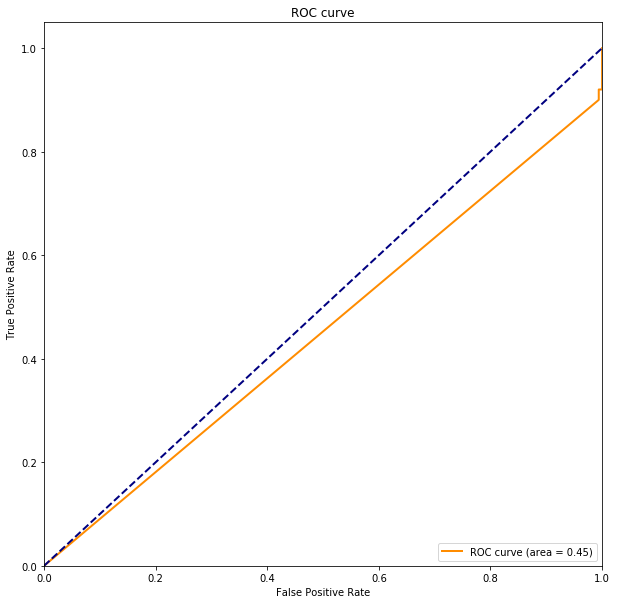

In [29]:
plt.figure(figsize=(10, 10))

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")

plt.show()